In [1]:
import numpy as np
import torch as torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils import data as data

In [2]:
DATA_FOLDER = "panneaux_route"
CLASSES = { 
    0:"Limitation de vitesse (20km/h)",
    1:"Limitation de vitesse (30km/h)", 
    2:"Limitation de vitesse (50km/h)", 
    3:"Limitation de vitesse (60km/h)", 
    4:"Limitation de vitesse (70km/h)", 
    5:"Limitation de vitesse (80km/h)", 
    6:"Fin de limitation de vitesse (80km/h)", 
    7:"Limitation de vitesse (100km/h)", 
    8:"Limitation de vitesse (120km/h)", 
    9:"Interdiction de depasser", 
    10:"Interdiction de depasser pour vehicules > 3.5t", 
    11:"Intersection ou' vous etes prioritaire", 
    12:"Route prioritaire", 
    13:"Ceder le passage", 
    14:"Arret a' l'intersection", 
    15:"Circulation interdite", 
    16:"Acces interdit aux vehicules > 3.5t", 
    17:"Sens interdit", 
    18:"Danger", 
    19:"Virage a' gauche", 
    20:"Virage a' droite", 
    21:"Succession de virages", 
    22:"Cassis ou dos-d'ane", 
    23:"Chaussee glissante", 
    24:"Chaussee retrecie par la droite", 
    25:"Travaux en cours", 
    26:"Annonce feux", 
    27:"Passage pietons", 
    28:"Endroit frequente' par les enfants", 
    29:"Debouche' de cyclistes", 
    30:"Neige ou glace",
    31:"Passage d'animaux sauvages", 
    32:"Fin des interdictions precedemment signalees", 
    33:"Direction obligatoire a' la prochaine intersection : a' droite", 
    34:"Direction obligatoire a' la prochaine intersection : a' gauche", 
    35:"Direction obligatoire a' la prochaine intersection : tout droit", 
    36:"Direction obligatoire a' la prochaine intersection : tout droit ou a' droite", 
    37:"Direction obligatoire a' la prochaine intersection : tout droit ou a' gauche", 
    38:"Contournement obligatoire de l'obstacle par la droite", 
    39:"Contournement obligatoire de l'obstacle par la gauche", 
    40:"Carrefour giratoire", 
    41:"Fin d'interdiction de depasser", 
    42:"Fin d'interdiction de depasser pour vehicules > 3.5t" 
}


(tensor([[[0.2941, 0.2902, 0.3255,  ..., 0.2627, 0.2549, 0.2588],
         [0.3216, 0.3098, 0.3451,  ..., 0.2863, 0.2980, 0.3098],
         [0.3098, 0.3294, 0.3569,  ..., 0.2824, 0.2902, 0.3059],
         ...,
         [0.4941, 0.4667, 0.4235,  ..., 0.3804, 0.3882, 0.3882],
         [0.3529, 0.3569, 0.3020,  ..., 0.4118, 0.4196, 0.3725],
         [0.3333, 0.3686, 0.2706,  ..., 0.3961, 0.3843, 0.3529]],

        [[0.3059, 0.2980, 0.3294,  ..., 0.2902, 0.2706, 0.2627],
         [0.3255, 0.3176, 0.3412,  ..., 0.3020, 0.3020, 0.3098],
         [0.3098, 0.3294, 0.3490,  ..., 0.2902, 0.2941, 0.3059],
         ...,
         [0.5020, 0.4824, 0.4588,  ..., 0.3765, 0.3961, 0.4039],
         [0.3686, 0.3843, 0.3412,  ..., 0.4078, 0.4353, 0.4039],
         [0.3294, 0.3882, 0.3137,  ..., 0.4000, 0.3961, 0.3804]],

        [[0.3137, 0.3059, 0.3255,  ..., 0.2863, 0.2667, 0.2588],
         [0.3333, 0.3255, 0.3294,  ..., 0.3020, 0.2902, 0.3020],
         [0.3176, 0.3333, 0.3490,  ..., 0.2824, 0.2784, 0

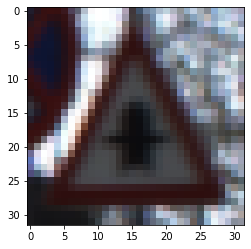

In [3]:
######### DATA SETS #########
from torch.utils.data import Dataset, DataLoader

trainingset = datasets.ImageFolder("panneaux_route/Train", transform=transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor()]
))

print(trainingset[0])
print(CLASSES.get(int(trainingset.classes[trainingset[5005][1]]))), plt.imshow(trainingset[5005][0].permute(1,2,0))

trainSize = int(0.8 * len(trainingset))
validationSize = len(trainingset) - trainSize
trainDataset, validationDataset = data.random_split(trainingset, [trainSize, validationSize])

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
validationLoader = DataLoader(validationDataset, batch_size=1024)

In [4]:
######### COMBIEN DE DONNEES PAR CLASSE #########
def check_repartition(dico, dataset) :
    for images, label in dataset :
        if label in dico :
            dico[label] += 1
        else :
            dico[label] = 1

In [5]:
######### VERIFIONS LA REPARTITION DES DONNEES #########
check_init = {}
check_repartition(check_init, trainingset)

check_traindataset = {}
check_repartition(check_traindataset, trainDataset)

check_valid = {}
check_repartition(check_valid, validationDataset)


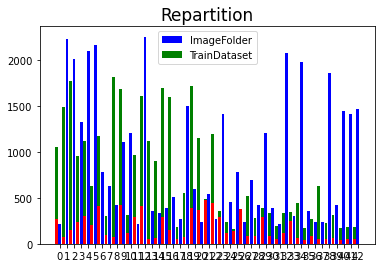

In [6]:
X = np.arange(len(check_init))
ax = plt.subplot(111)
ax.bar(X, check_init.values(), width=0.4, color='b', align='center')
ax.bar(X-0.5, check_traindataset.values(), width=0.4, color='g', align='center')
ax.bar(X-0.5, check_valid.values(), width= 0.4, color='r', align='center')
ax.legend(('ImageFolder','TrainDataset'))
plt.xticks(X, check_init.keys())
plt.title("Repartition", fontsize=17)

plt.show()

In [12]:
######### TRAIN LOOP #########
def train_loop(train_loader, model, loss_map, lr=1e-3, epochs=20):
    history = []
    # use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    # create optimizer
    optimizer = Adam(model.parameters(), lr=lr)
    # Train model
    for epoch in range(epochs):
        loss_epoch = 0.
        for images, labels in train_loader:
            # Transfers data to GPU
            #images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)            
            loss = loss_map(output, labels)            
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
        # display the epoch training loss
        test_acc = validate(validationLoader, model)
        history.append(
            {'epoch' : epoch + 1,
             'loss' : loss_epoch,
             'test_acc' : test_acc})
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, test_acc = {test_acc}%")
    return history

In [13]:
######### VALIDATION #########
def validate(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images)
        nb_errors += ((output.argmax(1)) != labels).sum()
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

def validate2(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(trainingset.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

In [14]:
######### MODEL(S) #########
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 120, kernel_size=(5, 5))
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 43)

    def forward(self, input):
        layer1 = F.relu(self.conv1(input))                          
        layer2 = F.max_pool2d(layer1, kernel_size=(2, 2), stride=2) 
        layer3 = F.relu(self.conv2(layer2))                         
        layer4 = F.max_pool2d(layer3, kernel_size=(2, 2), stride=2) 
        layer5 = F.relu(self.conv3(layer4))                         
        layer6 = F.relu(self.fc1(torch.flatten(layer5,1)))          
        layer7 = self.fc2(layer6)                                   
        return layer7

In [15]:
lenet = LeNet5()

In [16]:
print(f"Lenet before learning, accuracy = {validate(validationLoader, lenet)}%")
h = train_loop(
    train_loader=trainLoader, 
    model=lenet, 
    loss_map=nn.CrossEntropyLoss(),
    lr=0.003,
    epochs=15)
#print(h)
print(f"Lenet after learning, accuracy = {validate(validationLoader, lenet)}%")

Lenet before learning, accuracy = 3.8638102524866107%
cpu
epoch : 1/15, loss = 334.813755, test_acc = 54.934967041015625%
epoch : 2/15, loss = 114.540517, test_acc = 81.2165298461914%
epoch : 3/15, loss = 54.405890, test_acc = 86.68707275390625%
epoch : 4/15, loss = 34.040040, test_acc = 92.69319152832031%
epoch : 5/15, loss = 23.522547, test_acc = 94.61872100830078%
epoch : 6/15, loss = 16.947623, test_acc = 94.9120101928711%
epoch : 7/15, loss = 12.928339, test_acc = 96.45498657226562%
epoch : 8/15, loss = 10.081892, test_acc = 96.8885498046875%
epoch : 9/15, loss = 8.531849, test_acc = 96.59525299072266%
epoch : 10/15, loss = 7.727352, test_acc = 96.92680358886719%
epoch : 11/15, loss = 5.504425, test_acc = 97.84494018554688%
epoch : 12/15, loss = 4.769533, test_acc = 97.66641235351562%
epoch : 13/15, loss = 5.178285, test_acc = 97.52613830566406%
epoch : 14/15, loss = 4.135789, test_acc = 97.65365600585938%
epoch : 15/15, loss = 4.713309, test_acc = 97.89594268798828%
Lenet after l

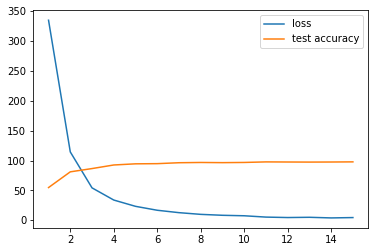

In [17]:
def show_learning(history):
    fig, ax = plt.subplots()
    ax.plot([h['epoch'] for h in history], [h['loss'] for h in history], label='loss')
    ax.plot([h['epoch'] for h in history], [h['test_acc'] for h in history], label='test accuracy')
    plt.legend()
    plt.show()
show_learning(h)

In [18]:
######### FINAL TEST #########
df = pd.read_csv('panneaux_route/Test.csv', sep=',')
trans = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
labels = df['ClassId'].tolist()
images = df['Path'].tolist()
img_lst = []

for img in images :
    img = "panneaux_route/" + img
    img_lst.append(trans(Image.open(img)))

In [19]:
class MyDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [20]:
test_dataset = MyDataSet(img_lst, labels)
test_dataloader = DataLoader(test_dataset, batch_size=256)
print(f"Lenet after learning, accuracy = {validate(test_dataloader, lenet)}%")

Lenet after learning, accuracy = 5.882818698883057%


16
tensor([16,  1, 38, 33, 11, 38, 18, 12, 25, 35, 12,  7, 23,  7,  4,  9, 21, 20,
        27, 38,  4, 33,  9,  3,  1, 11, 13, 10,  9, 11,  5, 17, 34, 23,  2, 17,
         3, 12, 16,  8,  7, 30, 18, 12, 24, 25,  3, 10, 18,  8, 25, 13, 15,  9,
        13, 35,  5, 26,  9, 16, 38, 10,  4,  9, 15,  9, 26,  2,  5, 28, 11, 25,
        30, 34,  5, 12,  1, 10, 25, 25, 21, 33, 25,  7, 10, 35,  3,  7, 22, 13,
         3,  1,  2, 14, 12, 32,  3, 38,  9, 33,  1, 10,  5, 11, 33,  4, 35, 25,
        33,  4,  1, 14, 16, 10, 30,  3, 27, 29,  1, 17, 13,  7,  1,  8,  2, 10,
        10, 30,  1,  6, 36,  3, 14, 13, 11, 10, 18, 40,  2, 38, 41,  4,  6, 18,
        17, 25,  2, 41, 11, 21,  7, 24, 11, 25, 17,  3,  6,  9,  7,  4, 13, 16,
         4, 25, 18,  9, 13, 14, 29, 17, 13, 38, 26, 25, 33,  1,  3, 40, 13,  2,
         8,  4, 36, 25, 20, 25, 18,  1, 10,  8, 10, 29, 12, 38, 31,  2,  8, 38,
        18, 28, 17,  9,  4,  1, 17,  9,  2, 31, 13, 15, 15, 38, 25,  5, 25, 13,
        10,  5,  4, 10,  2,  4,  5,  

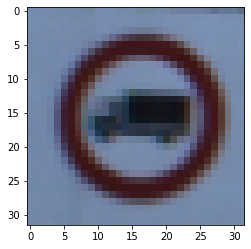

In [21]:
count = 0
for i, (images, labels) in enumerate(test_dataloader):
    if count > 0 : break
    for img in images : 
        plt.imshow(img.permute(1,2,0))
        break
    predictions = lenet(images.view(-1, 3, 32, 32)).argmax(1)

    print(trainingset.classes[8])
    print(labels)
    count+=1


In [22]:
def validate2(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(trainingset.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

In [23]:
print(validate2(test_dataloader, lenet))

90.13460015835312
